# Topic modeling

### Instructions

Topic Modelling is an NLP method to identify and extract the hidden topics from a large corpus of
textual data. As discussed in the previous lectures and hands-on exercises, you can use Latent Dirichlet
Allocation [8], which is a popular algorithm for topic modeling with an excellent implementation in
Gensim python package [9]. You can use the Gensim python package to build topic models on a
Diabetes labeled dataset consisting of texts collected from 42 online forums. Again, the challenge in
Topic modeling, in general, is to guess/identify the number of topics and also to extract good quality
topics which are clear, segregated, and somewhat meaningful which really depends on finding the
optimal number of topics. Therefore, try different combinations of topic numbers (maybe 5, 10, or
15) to figure out some sensible topics from the given Diabetes labeled dataset.


### Inspiration resource 
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### imports

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# preprocessing
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS

# Plotting tools
import pyLDAvis # you might need to run: `pip install pyLDAvis`
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt

### Dataset

In [2]:
df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Emotions')
#df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Patient-journey')

X = df.loc[:,'discussion_text']

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Preprocessing

In [3]:
# This is the same preprocessing we used in logistical regression with slight modifications 

# Basic function to clean the text
def clean_text(text):
 
    # remove numbers 
    text = re.sub(r'\d+', '', text)

    # remove all links
    text = re.sub(
        r"(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))", 
        'link_to_website', 
        text
    )

    # Removing spaces and converting text into lowercase
    return text.strip().lower()


# Create our list of punctuation marks
punctuations = string.punctuation
punctuations += "...."

# Create our list of stopwords
stop_words = STOP_WORDS 

# Load English tokenizer, tagger, parser, NER and word vectors
parser = spacy.load('en_core_web_sm')


# Creating our tokenizer function
def spacy_tokenizer(sentence, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens if word.pos_ in allowed_postags]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

X = [spacy_tokenizer(clean_text(text)) for text in X]

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Creating Dictionary and corpus

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(X)

# Create Corpus
texts = X

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2)]]


D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Building LDA (Latent Dirichlet Allocation) model

In [6]:
lda_model = gensim.models.ldamodel.LdaModel(
  corpus=corpus,
  id2word=id2word,
  num_topics=12, 
  random_state=100,
  update_every=1,
  chunksize=100,
  passes=10,
  alpha='auto',
  per_word_topics=True
)

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### View topics

In [7]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.049*"hbac" + 0.044*"meter" + 0.037*"answer" + 0.036*"option" + '
  '0.036*"continue" + 0.034*"struggle" + 0.029*"short" + 0.023*"enjoy" + '
  '0.020*"sound" + 0.020*"money"'),
 (1,
  '0.049*"foot" + 0.041*"eye" + 0.038*"place" + 0.029*"welcome" + 0.028*"leg" '
  '+ 0.025*"neuropathy" + 0.024*"suffer" + 0.024*"totally" + 0.024*"soda" + '
  '0.023*"community"'),
 (2,
  '0.055*"know" + 0.046*"good" + 0.042*"test" + 0.042*"t" + 0.037*"doctor" + '
  '0.028*"feel" + 0.026*"thing" + 0.024*"read" + 0.024*"want" + 0.022*"find"'),
 (3,
  '0.081*"little" + 0.046*"night" + 0.033*"dad" + 0.030*"notice" + '
  '0.030*"fine" + 0.025*"kid" + 0.022*"quit" + 0.021*"wake" + 0.018*"battle" + '
  '0.017*"fairly"'),
 (4,
  '0.052*"appointment" + 0.049*"system" + 0.042*"worry" + 0.038*"birth" + '
  '0.034*"wait" + 0.030*"urine" + 0.024*"drive" + 0.022*"bed" + 0.019*"list" + '
  '0.017*"complete"'),
 (5,
  '0.120*"diabetes" + 0.095*"type" + 0.025*"insulin" + 0.025*"year" + '
  '0.020*"diagnose" + 0.0

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Show model complexity and coherence

In [8]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=X, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -8.235763055915513

Coherence Score:  0.4829283839268758


### Visualize the topics

In [9]:
pyLDAvis.enable_notebook()
lda_viz = gensimvis.prepare(lda_model, corpus, id2word)
lda_viz

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.309977 -0.048595       1        1  42.119774
7      0.231544  0.253404       2        1  15.571263
2      0.163380 -0.364410       3        1  12.319733
10     0.156365  0.094030       4        1   9.431618
8      0.019928  0.064917       5        1   7.379696
9     -0.093804  0.014176       6        1   2.776549
6     -0.108308  0.002026       7        1   2.681822
11    -0.115394 -0.027853       8        1   2.150926
0     -0.140405  0.002791       9        1   1.604043
1     -0.137016  0.003262      10        1   1.431858
3     -0.140344  0.002820      11        1   1.427748
4     -0.145923  0.003431      12        1   1.104971, topic_info=           Term         Freq        Total Category  logprob  loglift
4      diabetes  5142.000000  5142.000000  Default  30.0000  30.0000
13         type  4095.000000  4095.000000  Default  29.0000  29.0000
1         blood  1039.000000  1039.000000  Default  28.0000  28.0000
44        sugar   922.000000   922.000000  Default  27.0000  27.0000
197         eat  1038.000000  1038.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
5015         ob     9.908025    10.813766  Topic12  -4.7342   4.4179
321     company     9.737864    10.643614  Topic12  -4.7515   4.4164
1901  encounter     9.274319    10.180114  Topic12  -4.8003   4.4122
1224      apart     8.690430     9.596164  Topic12  -4.8653   4.4062
522       block     8.192778     9.098505  Topic12  -4.9243   4.4005

[441 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
1836      9  0.975094  absolute
1173      4  0.993877        ac
781       7  0.979992    active
832       8  0.975236  activity
2350      6  0.977034  addition
...     ...       ...       ...
1151     11  0.983445     white
271       1  0.998546      work
585      12  0.983962     worry
93        1  0.999384      year
5668      8  0.947255      zinc

[455 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 8, 3, 11, 9, 10, 7, 12, 1, 2, 4, 5])

### Finding optimal number of topics

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics, 
            random_state=100,
            update_every=1,
            chunksize=100,
            passes=10,
            alpha='auto',
            per_word_topics=True
        )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=X, start=2, limit=15, step=1)

D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


D:\Program Files\Anaconda\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


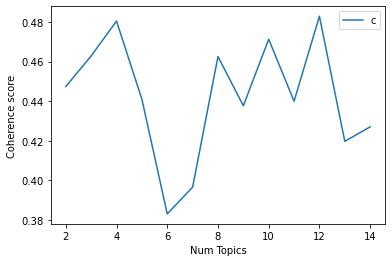

In [13]:
# Show graph
limit=15
start=2
step=1
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

from the graph above we can see that 12 (or 4) topics seem to have the highest coherence 